In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, MaxPooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Face Mask/With mask/dataset_raw.zip'

Archive:  /content/drive/MyDrive/Face Mask/With mask/dataset_raw.zip
   creating: dataset_raw/
   creating: dataset_raw/train/
   creating: dataset_raw/train/Non Mask/
  inflating: dataset_raw/train/Non Mask/non_mask_1875.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_2408.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_0301.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_1650.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_1680.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_1708.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_1750.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_1847.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_1854.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_0222.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_0253.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_0259.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_1946.jpg  
  inflating: dataset_raw/train/Non Mask/non_mask_197

In [ ]:
Y = [1]*len(os.listdir('/content/dataset_raw/train/Mask'))
Y.extend([0]*len(os.listdir('/content/dataset_raw/train/Non Mask')))
len(Y)

4000

In [ ]:
data = []
for i in os.listdir('/content/dataset_raw/train/Mask'):
  data.append(cv2.imread('/content/dataset_raw/train/Mask/'+i))

In [ ]:
for i in os.listdir('/content/dataset_raw/train/Non Mask'):
  data.append(cv2.imread('/content/dataset_raw/train/Non Mask/'+i))

In [ ]:
len(data)

4000

In [ ]:
def crop_img(img):
  x = int(img.shape[1]/2) - int(224/2)
  y = int(img.shape[0]/2) - int(224/2)

  image_mask = np.zeros(img.shape)
  image_mask[int(y):int(y+224), int(x):int(x+224)] = 1
  crop_img = img[int(y):int(y+224), int(x):int(x+224)]
  #cv2_imshow(crop_img)
  #cv2_imshow(img*image_mask)
  return crop_img

In [ ]:
def zoom_img(img):
  return cv2.resize(img, (224, 224))

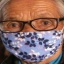

(64, 64, 3)

In [ ]:
cv2_imshow(data[0])
data[0].shape

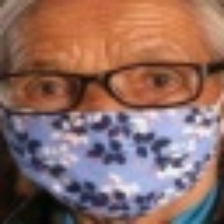

In [ ]:
cv2_imshow(zoom_img(data[0]))

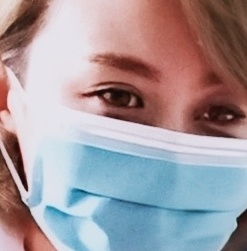

(251, 247, 3)

In [ ]:
cv2_imshow(data[10])
data[10].shape

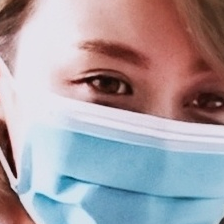

In [ ]:
cv2_imshow(crop_img(data[10]))

In [ ]:
def pre_processing(img):
  if img.shape[0] > 224 and img.shape[1] > 224:
    img = crop_img(img)
  else:
    img = zoom_img(img)
  return img

In [ ]:
for i in range(len(data)):
  data[i] = pre_processing(data[i])

In [ ]:
data = np.array(data, dtype="float32")
Y = np.array(Y)

In [ ]:
Y = LabelBinarizer().fit_transform(Y)
Y = to_categorical(Y)

In [ ]:
def data_split(data, Y):
  (trainX, testX, trainY, testY) = train_test_split(data, Y, test_size=0.20, stratify=Y, random_state=42)
  return (trainX, testX, trainY, testY)

In [ ]:
(trainX, testX, trainY, testY) = data_split(data, Y)

In [ ]:
def Model_create():
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  for layer in baseModel.layers:
	  layer.trainable = False

  model = baseModel.output
  model = MaxPooling2D(pool_size=(7, 7))(model)
  model = Flatten(name="flatten")(model)
  model = Dense(128, activation="relu")(model)
  model = Dropout(0.5)(model)
  model = Dense(2, activation="softmax")(model)

  M = Model(inputs=baseModel.input, outputs=model)
  #print(M.summary())
  return M

In [ ]:
M = Model_create()

In [ ]:
opt = Adam(lr=0.0001, decay=0.0001 / 10)
M.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
trainX.shape

(3200, 224, 224, 3)

In [ ]:
H = M.fit(
	trainX, trainY, batch_size=20,
	steps_per_epoch=len(trainX) // 20,
	validation_data=(testX, testY),
	validation_steps=len(testX) // 20,
	epochs=10)

Epoch 1/10
160/160 [==============================] - 109s 661ms/step - loss: 0.7370 - accuracy: 0.7809 - val_loss: 0.3036 - val_accuracy: 0.8925
Epoch 2/10
160/160 [==============================] - 105s 654ms/step - loss: 0.3283 - accuracy: 0.8775 - val_loss: 0.2509 - val_accuracy: 0.9137
Epoch 3/10
160/160 [==============================] - 104s 652ms/step - loss: 0.2745 - accuracy: 0.8981 - val_loss: 0.2258 - val_accuracy: 0.9175
Epoch 4/10
160/160 [==============================] - 104s 652ms/step - loss: 0.2442 - accuracy: 0.9091 - val_loss: 0.2058 - val_accuracy: 0.9237
Epoch 5/10
160/160 [==============================] - 105s 656ms/step - loss: 0.2228 - accuracy: 0.9131 - val_loss: 0.1973 - val_accuracy: 0.9275
Epoch 6/10
160/160 [==============================] - 104s 651ms/step - loss: 0.2036 - accuracy: 0.9256 - val_loss: 0.1812 - val_accuracy: 0.9388
Epoch 7/10
160/160 [==============================] - 104s 652ms/step - loss: 0.1875 - accuracy: 0.9272 - val_loss: 0.1718 -

In [ ]:
predIdxs = M.predict(testX, batch_size=20)

In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['Mask','No Mask']))

              precision    recall  f1-score   support

        Mask       0.95      0.95      0.95       400
     No Mask       0.95      0.95      0.95       400

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



In [ ]:
model.save('/content/drive/MyDrive/Face Mask/mask-detector-model.model', save_format="h5")
print("Done !")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Done !


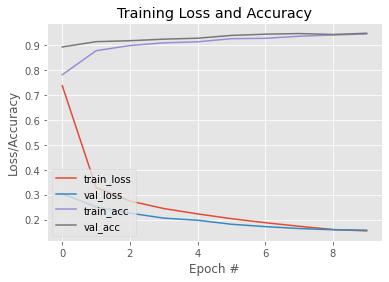

In [ ]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')

In [ ]:
def testing(path):
  tst = cv2.imread(path)
  cv2_imshow(tst)
  tst = pre_processing(tst)
  tst = np.reshape(tst, (1, 224, 224, 3))
  cls = np.argmax(M.predict(tst)[0])
  if cls == 1:
    print('With Mask')
  else:
    print('Without Mask')

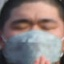

With Mask


In [ ]:
testing('/content/dataset_raw/test/Mask/mask_0002.jpg')


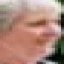

Without Mask


In [ ]:
testing('/content/dataset_raw/test/Non Mask/non_mask_0006.jpg')